# Polynomial Gradients

We carry out two experiments in this blog post, using some existing functionality in equadratures (following the discovery of a small but gradient-functionality-thwarting bug). Both experiments utilise the following bivariate function

$$
f\left(x_1, x_2 \right) = 2x_1^3 - 3x_1 x_2 + 5x_1^2 + 3 sin(x_1)
$$

where $x_1 \in [-3, 2]$ and $x_2 \in [-3,2]$. For this function, analytical gradients can be readily computed to be

$$
\nabla_{x_1} f\left(x_1, x_2 \right) = 6 x_1^2 - 3x_2 + 3  cos(x_1),
$$

and 

$$
\nabla_{x_2} f\left(x_1, x_2 \right) = -3x_1 + 10*x_2
$$

The code block below captures this.

In [1]:
from equadratures import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def fun(x):
    return 2*x[0]**3 - 3*x[0]*x[1] + 5*x[1]**2 + 3 * np.sin(x[0])

def grads(x):
    y1 = 6*x[0]**2 - 3*x[1] + 3 * np.cos(x[0])
    y2 = -3*x[0] + 10*x[1]
    return [y1, y2]

In [2]:
import equadratures as eq
eq.__version__

'10.0.0.1'

The broader motivation for this blog post is the ever-increasing use of adjoint evaluations in computational simulation workflows to estimate gradients. 

**Experiment 1. Estimate the gradients of a polynomial approximation**

Our first port of call will be to sample this function at *effectively subsampled quadrature points* (incidently the namesake of our little organisation). For more information on how these points are different from more traditional tensor- and sparse-grid quadrature rules, do check out [1, 2]. 


In [3]:
param = Parameter(distribution='uniform', lower=-3., upper=2., order=3)
basis = Basis('total-order')
poly = Poly([param, param], basis, \
            method='least-squares', \
            sampling_args={'mesh': 'tensor-grid', \
            'subsampling-algorithm' : 'qr', 'subsampling-ratio': 1.0})
X = poly.get_points()
poly.set_model(model=fun)

The code block above will construct a bivariate polynomial approximation using only ten quadrature points: ten because that corresponds to the cardinality of the multi-index set (check out [this](https://www.equadratures.org/docs/_documentation/tutorial_5.html) tutorial). 

To plot the polynomial, we have


In [4]:
K = 20
xx = np.linspace(-3, 2, K)
Xo, Yo = np.meshgrid(xx, xx)
Xi = Xo.reshape(K*K, 1)
Yi = Yo.reshape(K*K, 1)
X_test = np.hstack([Xi, Yi]) 
Y_test = poly.get_polyfit(X_test)

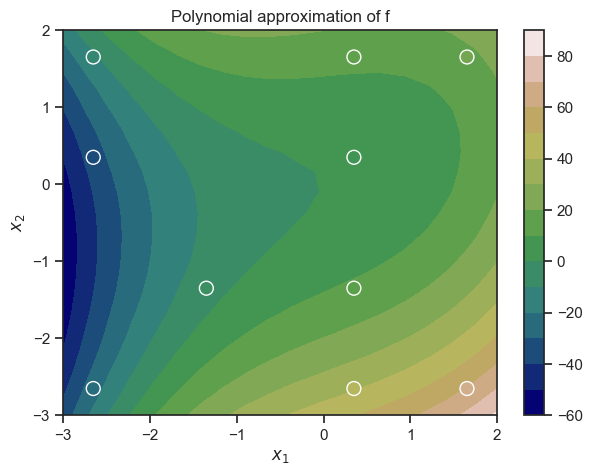

In [5]:
fig = plt.figure(figsize=(7, 5))
plt.title('Polynomial approximation of f')
norm = matplotlib.colors.Normalize(vmin=np.min(Y_test),vmax=np.max(Y_test))
c = plt.contourf(Xo, Yo, Y_test.reshape(K, K), cmap='gist_earth', levels=15)
plt.scatter(X[:,0], X[:,1], c=poly._model_evaluations, s=100, zorder=2, edgecolor='white', norm=norm, label='Quadrature points', cmap='gist_earth')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(c)
plt.show()

A `Poly` instance has a `get_polyfit_grad()` function that evaluates the analytical gradient of the polynomial approximation. More specifically, if we assume our function can be written by the approximation

$$
f\left(x_{1},x_{2}\right)\approx\sum_{i=1}^{N}\alpha_{i}\phi_{i}\left(x_{1},x_{2}\right),
$$

where $\alpha_i$ is the $i$-th polynomial coefficient associated with the bivariate orthogonal polynomial $\phi_{i}$, then its gradients are simply given by

$$
\nabla_{x_{1}}f\left(x_{1},x_{2}\right)\approx\sum_{i=1}^{N}\alpha_{i}\frac{\partial\phi\left(x_{1},x_{2}\right)}{\partial x_{1}}
$$

and 

$$
\nabla_{x_{2}}f\left(x_{1},x_{2}\right)\approx\sum_{i=1}^{N}\alpha_{i}\frac{\partial\phi\left(x_{1},x_{2}\right)}{\partial x_{2}}.
$$

To see this in action, we execute the code block below

    

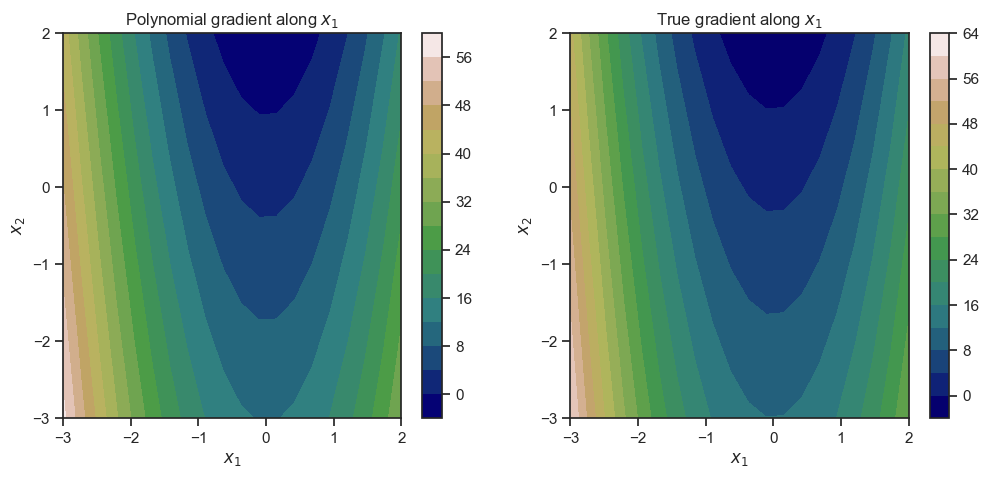

In [6]:
dY_test = poly.get_polyfit_grad(X_test)
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Polynomial gradient along $x_1$')
# dY_test[0] corresponds to the gradient associated with x_1
c = plt.contourf(Xo, Yo, dY_test[0].reshape(K, K), cmap='gist_earth', levels=15)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(c)
plt.subplot(122)
plt.title('True gradient along $x_1$')
c2 = plt.contourf(Xo, Yo, 6*Xo**2 - 3*Yo + 3 * np.cos(Xo), cmap='gist_earth', levels=15)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(c2)
plt.show()

It should be clear that although our polynomial approximation, and by consequence its gradients, have some approximation error, they offer a fairly accurate estimate of the underlying response surface.

**Experiment 2. Exploit gradient observations to construct a polynomial approximation**

We now move to our second, and arguably more challenging experiment. We want to exploit gradient observations, in addition to function evaluations, to inform a polynomial approximation. There are two ways to achieve this. The first is to use the additional (gradient) information to increase the number of basis terms, and thus hopefully, polynomial approximation accuracy. The second is to drastically reduce (where *drastically* implies a scaling with dimension) the number of quadrature points requested. 

To set the stage, we execute the following lines of code.

In [7]:
del param, basis, poly
param = Parameter(distribution='uniform', lower=-3., upper=2., order=3)
basis = Basis('total-order')
X_used = X[0:-6,:]
y = evaluate_model(X_used, fun)
dy = evaluate_model_gradients(X_used, grads, format='matrix')

followed by the initialisation of a new `Poly` object, but this time invoking the `least-squares-with-gradients` option.


In [8]:
poly = Poly([param, param], basis, \
    method='least-squares-with-gradients', \
    sampling_args={'mesh': 'user-defined', \
    'sample-points': X_used, 'sample-outputs': y,'sample-gradients':dy})

Note that we have restricted our polynomial to use only 4 quadrature points, but we stil have 10 basis terms and thus 10 unknowns! However, as we are leveraging the gradient evaluations at these 4 points, we can still solve the linear system. ``equadratures`` determines the rank of a *stacked* matrix, which stacks terms associated with $\phi \left(x_1, x_2 \right)$, $\frac{\partial\phi\left(x_{1},x_{2}\right)}{\partial x_{1}}$, and $\frac{\partial\phi\left(x_{1},x_{2}\right)}{\partial x_{2}}$. In our case, with 4 points, we get the following message.

In [9]:
poly.gradients

array([[ 11.18691619,  11.56988545],
       [ 34.61810414,  24.48693013],
       [ 24.10396086, -31.48693013],
       [ 47.53514881, -18.56988545]])

In [10]:
poly.gradient_flag

True

In [11]:
poly.set_model()

Gradient computation: The rank of the stacked matrix is 10.
The number of unknown basis terms is 10


And yes, we intentionally selected 4 quadrature points such that the rank of the *stacked* matrix is 10. Now we can plot the resulting approximations.

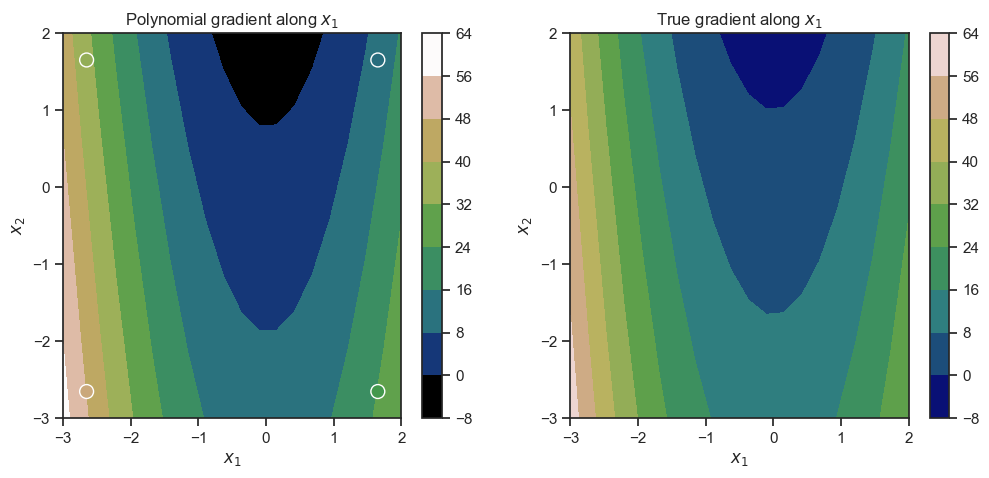

In [12]:
Y_test = poly.get_polyfit(X_test)
dY_test = poly.get_polyfit_grad(X_test)
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Polynomial gradient along $x_1$')
norm = matplotlib.colors.Normalize(vmin=np.min(dY_test[0]),vmax=np.max(dY_test[0]))
plt.scatter(X_used[:,0], X_used[:,1], c=dy[:,0], s=100, zorder=2, edgecolor='white', norm=norm, label='Quadrature points', cmap='gist_earth')
c = plt.contourf(Xo, Yo, dY_test[0].reshape(K, K), norm=norm, cmap='gist_earth')
plt.colorbar(c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.subplot(122)
plt.title('True gradient along $x_1$')
c2 = plt.contourf(Xo, Yo, 6*Xo**2 - 3*Yo + 3 * np.cos(Xo), cmap='gist_earth')
plt.colorbar(c2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


**References**

[1]. Seshadri, P., Iaccarino, G., Ghisu, T., (2019) Quadrature Strategies for Constructing Polynomial Approximations. *Uncertainty Modeling for Engineering Applications*. Springer, Cham, 2019. 1-25.

[2] Seshadri, P., Narayan, A., Sankaran M., (2017) Effectively Subsampled Quadratures for Least Squares Polynomial Approximations." *SIAM/ASA Journal on Uncertainty Quantification* 5.1 : 1003-1023.